First, let's load the dataset.

In [11]:
import pandas as pd

DATASET_PATH = "../data/docee/18091999/train.csv"
df = pd.read_csv(DATASET_PATH)
print(f"Loaded {len(df)} examples.")
df.head()

Loaded 17559 examples.


,index,title,text,event_type,arguments,date,metadata
0,0,North Korea responds to nearby joint United St...,"North Korea says it will use its ""nuclear dete...",Military Exercise,"[{'start': 74, 'end': 75, 'type': 'Countries p...",July 2010,['(BBC)']
1,1,"5,300 people flee flames which thousands of fi...",VANCOUVER — More than 100 new forest fires are...,Fire,"[{'start': 68, 'end': 92, 'type': 'Location', ...",August 2009,"['(BBC)', '(Canada.com)', '(CBS News)', '(Nati..."
2,2,Trans-Canada Air Lines Flight 831 crash,Trans-Canada Air Lines (TCA) Flight 831 was a ...,Air crash,"[{'start': 0, 'end': 27, 'type': 'Agency to wh...",NaN,NaN
3,3,Severe drought conditions continue in Zimbabwe...,As severe drought conditions continue in Zimba...,Droughts,"[{'start': 41, 'end': 48, 'type': 'Areas Affec...",December 2019,"['(Catholic News Agency)', '(Bloomberg News)']"
4,4,"Saudi Arabian blogger Raif Badawi, who has bee...",Raif Badawi is the laureate of this year's Sak...,Awards ceremony,"[{'start': 0, 'end': 10, 'type': 'Winner', 'te...",October 2015,"['(Reuters)', '(Al Jazeera)', '(EU)']"


Before proceeding, let's get rid of unnamed rows. This operation is idempotent, so it can safely be run multiple times.

In [10]:
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df.to_csv(DATASET_PATH, index_label="index")

Now, let's split the dataset according to the presence of `data` attribute. Wiki articles do not have this attribute set, while news articles do.

In [7]:
df_news = df.loc[~df["date"].isna(), :]
print(f"Extracted {len(df_news)} news examples")

Extracted 10058 news examples


In [8]:
df_wiki = df.loc[df["date"].isna(), :]
print(f"Extracted {len(df_wiki)} wiki examples")

Extracted 7501 wiki examples


Let's check the class distribution.
We want to create a two-dimensional visual structure. One dimension represents the class name, while the other dimension represents the example count.

Class name is a categorical value, while example count is quantitative ordinal.
We can use a bar plot to show this.

Total of 59 class names.
Sum of all class counts equals 17559.


<BarContainer object of 59 artists>

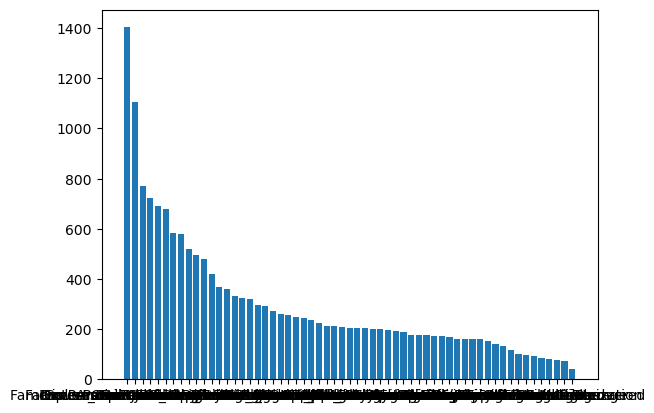

In [19]:
import matplotlib.pyplot as plt
import numpy as np

class_names = set(df["event_type"].tolist())
print(f"Total of {len(class_names)} class names.")

class_counts = {
    class_name: np.sum(df.event_type.values == class_name)
    for class_name in class_names
}
print(f"Sum of all class counts equals {sum(class_counts.values())}.")

class_counts = dict(sorted(class_counts.items(), key=lambda e: e[1], reverse=True))

plt.bar(
    class_counts.keys(),
    class_counts.values(),
)

Since we initially want to augment only low-resource classes, we should specify a cutoff threshold and take only classes for which the example count is less than the threshold.

In [22]:
CUTOFF_COUNT = 300
low_resource_classes = list(filter(lambda k: class_counts[k] <= CUTOFF_COUNT, class_counts))
print(f"Extracted {len(low_resource_classes)} low resource classes.")
print(low_resource_classes)

Extracted 42 low resource classes.
['Strike', 'Government Job change - Appoint_Inauguration', 'Famous Person - Commit Crime - Arrest', 'Road Crash', 'Organization Closed', 'Environment Pollution', 'Break historical records', 'Gas explosion', 'Bank Robbery', 'Awards ceremony', 'Shipwreck', 'Famous Person - Give a speech', 'Sign Agreement', 'Mine Collapses', 'Mass Poisoning', 'New achievements in aerospace', 'Military Exercise', 'Financial Crisis', 'Famous Person - Commit Crime - Release', 'Train collisions', 'Withdraw from an Organization', 'Diplomatic Visit', 'Insect Disaster', 'Organization Fine', 'Famous Person - Commit Crime - Investigate', 'New wonders in nature', 'Volcano Eruption', 'Organization Merge', 'Famous Person - Sick', 'New archeological discoveries', 'Famine', 'Tear Up Agreement', 'Financial Aid', 'Famous Person - Marriage', 'Organization Established', 'Famous Person - Divorce', 'Tsunamis', 'Droughts', 'Famous Person - Recovered', 'Mudslides', 'Join in an Organization', 

Once we have our low resource classes, we would like to compare event detection performance before and after augmentation.

The dataset will be augmented by adding, for each example, its summary as produced by a trained BART model. Such augmentation is performed under the assumption that the class label (i.e. event type) is unchanged if the document is summarized.

The research hypothesis that we're testing is as follows:
"If abstractive summarization is unsuccessful as an augmentation method for document-level event detection, then no statistically significant performance gains will be observed."

TODO: implement per-class evaluation of model performance
TODO: determine the procedure of testing for statistical significance.

As a final step of this prototyping notebook, we will do the following:
    1) load the training split
    2) for extraction_prodecure in (before newswiki, after newswiki):
        3) extract low-resource classes
        4) save the portion of the dataset

In [29]:
from pprint import pprint
import os
from typing import TypeAlias, Callable, TypeVar, Tuple

# extraction_strategy :: pd.DataFrame -> (Pd.DataFrame, pd.DataFrame)
ExtractionStrategy: TypeAlias = Callable[[pd.DataFrame], Tuple[pd.DataFrame, pd.DataFrame]]

def low_resource_dataset_pipeline(
        load_path: str,
        extraction_strategy: ExtractionStrategy,
        save_path: str
) -> None:
    # load dataset from the given path
    df = pd.read_csv(load_path)
    print(f"Low resource dataset pipeline loaded {len(df)} rows "
          f"from {load_path}")
    pprint(df.head())

    # extract news and wiki, according to some extraction strategy
    news_df, wiki_df = extraction_strategy(df)

    # save extracted datasets to save path
    news_save_path = os.path.join(save_path, "train_news.csv")
    news_df.to_csv(
        os.path.join(save_path, "train_news.csv"),
        index=False
    )
    print(f"Low reseource dataset pipeline saved news_df to {news_save_path}")

    wiki_save_path = os.path.join(save_path, "train_wiki.csv")
    wiki_df.to_csv(
        os.path.join(save_path, "train_wiki.csv"),
        index=False
    )
    print(f"Low reseource dataset pipeline saved wiki_df to {wiki_save_path}")

def extract_low_resource_classes(
        df: pd.DataFrame,
        cutoff: int
) -> pd.DataFrame:
    # keeps only examples from classes which contain no more than `cutoff` elements

    # extract class names
    class_names = set(df["event_type"].tolist())
    print(f"Extracted {len(class_names)} unique class names.")

    # extract class counts
    class_counts = {
        class_name: np.sum(df.event_type.values == class_name)
        for class_name in class_names
    }

    # create a boolean mask
    return df.loc[
        df.apply(lambda x: class_counts[x["event_type"]] <= cutoff, axis=1),
        :
    ]


def extract_before_splitting(cutoff: int) -> ExtractionStrategy:
    def extraction_strategy(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        # first, extract low-resource classes
        df = extract_low_resource_classes(df, cutoff)

        # next, split by news/wiki
        df_news = df.loc[~df.date.isna(), :]
        df_wiki = df.loc[df.date.isna(), :]

        return df_news, df_wiki

    return extraction_strategy

In [30]:
low_resource_dataset_pipeline(
    "../data/docee/18091999/train.csv",
    extract_before_splitting(cutoff=300),
    "../data/docee/low_resource_augmentation"
)

Low resource dataset pipeline loaded 17559 rows from ../data/docee/18091999/train.csv
   index                                              title  \
0      0  North Korea responds to nearby joint United St...   
1      1  5,300 people flee flames which thousands of fi...   
2      2            Trans-Canada Air Lines Flight 831 crash   
3      3  Severe drought conditions continue in Zimbabwe...   
4      4  Saudi Arabian blogger Raif Badawi, who has bee...   

                                                text         event_type  \
0  North Korea says it will use its "nuclear dete...  Military Exercise   
1  VANCOUVER — More than 100 new forest fires are...               Fire   
2  Trans-Canada Air Lines (TCA) Flight 831 was a ...          Air crash   
3  As severe drought conditions continue in Zimba...           Droughts   
4  Raif Badawi is the laureate of this year's Sak...    Awards ceremony   

                                           arguments           date  \
0  [{'start':